In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import os

import datasets.toy_datasets as datasets
import utils.sde_lib as sdes
from utils.model_utils import get_preconditioned_model
from utils.models import MLP
from utils.misc import dotdict, batch_matrix_product

torch.set_printoptions(precision=3,sci_mode=False)

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
is_sb = False
is_cld = False
if is_sb:
    model_path = './checkpoints/spiral_sb_linear/itr_2000'
    model_path = './exp/itr_2000'
    
    backward_score = torch.load(os.path.join(model_path,'backward_ema_2000.pt'))
    forward_score = torch.load(os.path.join(model_path,'forward_ema_2000.pt'))
    sde = sdes.LinearSchrodingerBridge(forward_model=forward_score,backward_model=backward_score)
else:
    model_path = f'./checkpoints/spiral-{'cld' if is_cld else 'vp'}/itr_15000'
    backward_score = torch.load(os.path.join(model_path,'backward_ema.pt'))
    print(backward_score)
    sde = sdes.CLD(model_backward=backward_score) \
        if is_cld else sdes.VP(model_backward=backward_score)
    backward_score = get_preconditioned_model(backward_score, sde)
    sde.backward_score = backward_score    
    print(sde.backward_score)

MLP(
  (sequential): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): SiLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): SiLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): SiLU()
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)
PrecondVP(
  (net): MLP(
    (sequential): Sequential(
      (0): Linear(in_features=3, out_features=128, bias=True)
      (1): SiLU()
      (2): Linear(in_features=128, out_features=256, bias=True)
      (3): SiLU()
      (4): Linear(in_features=256, out_features=128, bias=True)
      (5): SiLU()
      (6): Linear(in_features=128, out_features=2, bias=True)
    )
  )
)


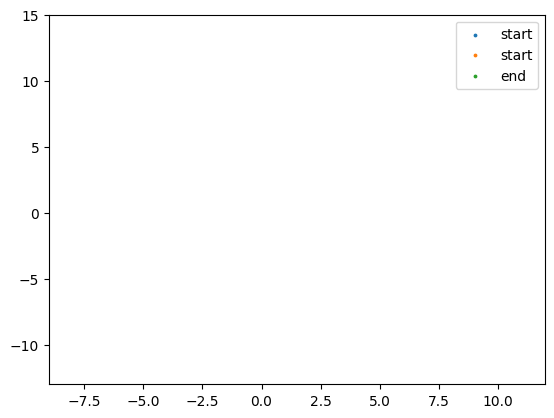

In [5]:
def plot_trajectories(traj):
    for i in range(traj.shape[1]):
        plt.clf()
        plt.scatter(traj[:,i,0].detach().cpu(), traj[:,i,1].detach().cpu())
        plt.xlim(-9,12)
        plt.ylim(-13,15)
        plt.savefig(f'trajectory/{i}.png')
    plt.clf()

dataset = datasets.Spiral()
n_samples = 500
in_cond = dataset.sample(n_samples).to(device=device)
if isinstance(sde,sdes.CLD):
    in_cond = torch.cat((in_cond,torch.randn_like(in_cond)),dim=1)
shape = (n_samples,4 if is_cld else 2)
xt, traj = sde.sample(shape, device, backward=False, in_cond=in_cond,prob_flow=True, return_traj=True)

plot_trajectories(traj)

for i in range(traj.shape[0]):
    xi = traj[i]
    plt.plot(xi[:,0].cpu(), xi[:,1].cpu(), linewidth=1, alpha=.3)

plt.scatter(traj[:,0,0].cpu(), traj[:,0,1].cpu(),s=3, label='start',zorder=1010)
plt.scatter(traj[:,0,0].cpu(), traj[:,0,1].cpu(),s=3, label='start',zorder=1010)
plt.scatter(traj[:,-1:,0].cpu(), traj[:,-1,1].cpu(), s=3,label='end')
plt.xlim(-9,12)
plt.ylim(-13,15)
plt.legend()
plt.show()

In [4]:
n_pts = 20
x_pts = torch.linspace(-5,5,n_pts,device=device)#.view(-1,1)
y_pts = torch.linspace(-27,32,n_pts, device=device)#.view(-1,1)
x_pts, y_pts = torch.meshgrid((x_pts,y_pts))
x_pts = x_pts.reshape(-1,1)
y_pts = y_pts.reshape(-1,1)
z_pts = torch.cat((x_pts,y_pts),dim=-1)
n_time = 100
times = torch.linspace(0,1,n_time,device=device).unsqueeze(-1)
dt = 1/n_time
xt = dataset.sample(1000).to(device=device)
noise = torch.randn_like(xt)
for i,t in enumerate(times):
    t_shape = t.expand(z_pts.shape[0]).unsqueeze(-1)
    
    vector_field = sde.probability_flow_drift(z_pts,t_shape)
    plt.xlim(-27,32)
    plt.ylim(-27,32)
    plt.quiver(x_pts.cpu(),y_pts.cpu(),vector_field[:,0].cpu(),vector_field[:,1].cpu())
    plt.scatter(xt[:,0].cpu(), xt[:,1].cpu(),alpha=.3)
    plt.scatter(noise[:,0].cpu(), noise[:,1].cpu(),alpha=.1)
    plt.savefig(f'./vector-field/{i}.png')
    plt.clf()
    xt = xt + sde.probability_flow_drift(xt,t.expand(xt.shape[0]).unsqueeze(-1)) * dt


/home/kevin/anaconda3/envs/variational/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/kevin/.local/lib/python3.12/site-packages/matplotlib/quiver.py:628: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
/home/kevin/.local/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


<Figure size 640x480 with 0 Axes>